### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
from shipping_audit_data import *

%matplotlib inline

### Script Settings

In [72]:
date_end = '2018-12-31'
quarter_end = '2018-Q4'
pretty_year_and_quarter = quarter_end[-2:] + ' ' + quarter_end[:4]

write_pdf = 'no'
report_dict = {}

image_path = '/Users/jarad/Fake Folder/Finance/Recurring/AdaBox Report/Images/'

html_path = '/Users/jarad/Fake Folder/Finance/Recurring/AdaBox Report/HTML/'
html_title = 'AdaBox Report.html'

style_sheet_path = '/Users/jarad/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

pdf_path = '/Users/jarad/Fake Folder/Finance/Recurring/AdaBox Report/Docs/Quarterly Reports/'

now_pretty = str(dt.datetime.now().date())

### Chart settings

In [3]:
p = '/Users/jarad/Fake Folder/Matplotlib Stylesheets/the_pillars_stylesheet.mplstyle'
plt.style.use(p)

adablue01 = '#00ffff'
adablue02 = '#00a6e9'
adapink = '#ff00ff'
adapurple = '#662d91'
adayellow = '#ffff00'
adagreen = '#00ff00'

colors = [adablue01, adablue02, adapink, adapurple, adayellow, adagreen]

### Links
* [Subscription model KPIs](https://subscriptionschool.com/guide/key-performance-indicators-subscription-boxes/)
* [AdaBox stats from plm](https://volcano.adafruit.com/volcano/ada_plm.php#/Stats/AdaBox?focus=Subscribers)

### Get subscriptions data

In [4]:
# this is a bird's-eye-view of each sub id, so no sub id dupes here
subs = pd.read_sql(
'''
SELECT
subscriptions_id,
orders_id,
customers_id,
IF(gifter_customers_id > 1, 'yes','no') AS gift,
DATE(date_created) AS date_created,
LOWER(subscriptions_status) AS account_status
FROM subscriptions
WHERE subscriptions_type = 'adabox'
''', db)
col_fix(subs)

# this is every move that some sub id made, so 0 to many sub id dupes here
subs_hist = pd.read_sql(
'''
SELECT
subscriptions_id,
orders_id,
LOWER(action) AS action,
DATE(timestamp) AS action_date,
LOWER(shipment_slug) AS shipment_slug,
LOWER(subscriptions_status) AS history_status
FROM subscriptions_history
''', db)

col_fix(subs_hist)

### Check for subs that are in one but not the other

In [5]:
s1 = set(subs['subscriptions id'])
s2 = set(subs_hist['subscriptions id'])
print('subscriptions ids not in both tables')
s3 = s1.symmetric_difference(s2)    
print(s3)

subscriptions ids not in both tables
{0, 5708, 6916}


### Create one dataframe

In [6]:
subs_main = subs_hist.copy()

# use the subscriptions_history as your main table, map these values from subscriptions table
ls = ['customers id','gift','date created','account status']
for col in ls:
    subs_main[col] = subs_main['subscriptions id'].map(dict(zip(subs['subscriptions id'], subs[col])))

### Check for nulls, store, and remove

In [7]:
print('actions where date_created is null\n')
vc = subs_main[subs_main['date created'].isnull()]['action'].value_counts()
print(vc)
print('\nstore these nulls and remove them')

nulls = subs_main[subs_main['date created'].isnull()]
subs_main.dropna(subset = ['date created'], inplace = True)

actions where date_created is null

update subscription      55702
create subscription          2
cancel subscription          2
create shipment order        1
Name: action, dtype: int64

store these nulls and remove them


In [8]:
nulls['subscriptions id'].value_counts()

0       55704
6916        2
5708        1
Name: subscriptions id, dtype: int64

### Create year and quarter

In [9]:
# to datetime
ls = ['action date','date created']
for col in ls:
    subs_main[col] = pd.to_datetime(subs_main[col])  

# create "year and quarter"
subs_main['year and quarter created'] = subs_main['date created'].dt.year.map(str) + '-Q' + subs_main['date created'].dt.quarter.map(str)
subs_main['year and quarter action'] = subs_main['action date'].dt.year.map(str) + '-Q' + subs_main['action date'].dt.quarter.map(str)

### Overall Summary
* Compare wtih [PLM AdaBox Stats](https://volcano.adafruit.com/volcano/ada_plm.php?/Stats/Subscriptions?focus=Subscribers)

In [10]:
df = subs_main.drop_duplicates('subscriptions id', keep = 'first')
plm = df['account status'].value_counts()
print(plm)

print('\nactive gift subscriptions')
print(np.sum((df['gift'] == 'yes') & (df['account status'] == 'active')))

active             3756
cancelled          2431
expired            1320
payment invalid       3
Name: account status, dtype: int64

active gift subscriptions
217


### Final touches

In [11]:
subs_main.drop_duplicates(inplace = True)

### Get orders data

In [12]:
oids = subs_main[subs_main['orders id'] > 0]['orders id'].tolist()

o = pd.read_sql(
'''
SELECT
o.orders_id,
shipping_module_code AS service,
shippingcost AS shipping_revenue,
os.orders_status_name,
'no' AS deleted
FROM orders o
JOIN orders_status os ON o.orders_status = os.orders_status_id
WHERE orders_id IN '''+ str(tuple(oids)) +'''
''', db)
col_fix(o)

od = pd.read_sql(
'''
SELECT
o.orders_id,
shipping_module_code AS service,
shippingcost AS shipping_revenue,
os.orders_status_name,
'yes' AS deleted
FROM orders_deleted o
JOIN orders_status os ON o.orders_status = os.orders_status_id
WHERE orders_id IN '''+ str(tuple(oids)) +'''
''', db)
col_fix(od)

orders = pd.concat([o,od], sort = False)
orders['orders status name'] = [x.lower() for x in orders['orders status name']]

# clean this up
d = {'':'no service',
    'dhlexpress':'dhl',
    'upsxml':'ups'}

for k,v in d.items():
    orders['service'] = orders['service'].replace(k,v)

In [13]:
ls = orders.columns.tolist()
ls.remove('orders id')

for col in ls:
    subs_main[col] = subs_main['orders id'].map(dict(zip(orders['orders id'], orders[col])))
    
n1 = subs_main[(subs_main['orders id'] > 0) & (subs_main.isnull().any(1))]
if n1.empty:
    pass
else:
    raise 0

### Get parts

In [14]:
parts = pd.read_sql(
'''
SELECT
orders_id,
op.part_id,
pd.products_name,
products_quantity - products_quantity_free AS qty_bought,
products_quantity_free AS qty_free,
products_quantity AS qty_total,
products_price
FROM orders_products op
JOIN products_description pd ON op.part_id = pd.part_id
WHERE orders_id IN '''+ str(tuple(oids)) +'''
''', db)

col_fix(parts)
parts['adabox'] = [x[:10].replace(' ','') for x in parts['products name']]

print('these are your adaboxes')
set(parts['adabox'])

these are your adaboxes


{'AdaBox001',
 'AdaBox002',
 'AdaBox003',
 'AdaBox004',
 'AdaBox005',
 'AdaBox006',
 'AdaBox007',
 'AdaBox008',
 'AdaBox009',
 'AdaBox010',
 'AdaBoxSub'}

### Get skus and cost

In [15]:
skus = pd.read_sql(
'''
SELECT
k.sku_id,
part_id,
sku_name,
sku_status,
manual_cost AS cost_per_unit,
consigned_manual_cost AS consigned_cost_per_unit,
sku_date_modified
FROM skus k
JOIN products_manufacturing pm ON k.sku_id = pm.sku_id
WHERE part_id IN '''+ str(tuple(parts['part id'].tolist())) +'''
''', db)

col_fix(skus)
skus = skus.sort_values(['part id','sku date modified']).drop_duplicates('part id', keep = 'last')

# if latest_cost = 0, replace with consigned_latest_cost
c = skus['cost per unit'].replace(0, skus['consigned cost per unit'])
skus['cost per unit'] = c

### Map parts and skus

In [16]:
for col in ['sku id','cost per unit']:
    parts[col] = parts['part id'].map(dict(zip(skus['part id'], skus[col])))
    
n = np.sum((parts.isnull().any(1)) & (parts['part id'] != 3067))
if n == 0:
    pass
else:
    raise 0

### Create columns

In [17]:
parts['revenue'] = parts['qty bought'] * parts['products price']
parts['total cost'] = parts['qty total'] * parts['cost per unit']
parts['gross profit'] = parts['revenue'] - parts['cost per unit']
parts['gross profit margin'] = parts['gross profit']/parts['revenue']

### All AdaBoxes

In [18]:
cols = ['sku id','part id','adabox','products price','cost per unit','revenue','gross profit','gross profit margin']
summary = parts[cols].drop_duplicates('adabox')
summary.format_([0,0,0,'m2','m2','m2','m2','p2']).replace([np.nan,'nan%','$nan'],'')

,Sku Id,Part Id,Adabox,Products Price,Cost Per Unit,Revenue,Gross Profit,Gross Profit Margin
0,,3067,AdaBoxSub,$0.00,,$0.00,,
480,12288,3193,AdaBox001,$60.00,$19.76,$60.00,$40.24,67.07%
2001,12306,3235,AdaBox002,$60.00,$24.47,$60.00,$35.53,59.22%
4489,12122,3268,AdaBox003,$60.00,$24.29,$60.00,$35.71,59.52%
7876,12071,3370,AdaBox004,$60.00,$20.24,$60.00,$39.76,66.26%
11416,10450,3476,AdaBox005,$60.00,$33.62,$60.00,$26.38,43.97%
15215,10730,3620,AdaBox006,$60.00,$27.80,$60.00,$32.20,53.66%
19543,10944,3696,AdaBox007,$60.00,$24.69,$60.00,$35.31,58.85%
23921,11575,3761,AdaBox008,$60.00,$31.21,$60.00,$28.79,47.98%
28046,12645,3863,AdaBox009,$60.00,$26.63,$60.00,$33.37,55.62%


### Map parts and subs_main

In [19]:
ls = parts.columns.tolist()
ls.remove('orders id')

for col in ls:
    subs_main[col] = subs_main['orders id'].map(dict(zip(parts['orders id'], parts[col])))
    
n2 = subs_main[(subs_main['orders id'] > 0)
            & (subs_main['deleted'] == 'no') 
            & (subs_main['orders status name'] == 'shipped')
            & (subs_main.isnull().any(1))]

if n2.empty:
    pass
else:
    raise 0

### Get shipping data

In [20]:
date_start = str(subs_hist['action date'].min())

shipping = get_shipping_audit_data(date_start, date_end)

# drop shipping data column called "adabox"
shipping.drop('adabox',1,inplace = True)


== shipping audit data start ==


== shipping audit data end ==



In [21]:
vc = subs_main[(~subs_main['orders id'].isin(shipping['orders id'].tolist()))
             & (subs_main['action'] == 'create shipment order')]['orders status name'].value_counts()

for ix in vc.index:
    if ix == 'shipped':
        raise ValueError('some shipments do not have billing data')

In [22]:
ls = shipping.columns.tolist()
ls.remove('orders id')

for col in ls:
    subs_main[col] = subs_main['orders id'].map(dict(zip(shipping['orders id'], shipping[col])))
    
n3 = subs_main[(subs_main['orders id'] > 0)
            & (subs_main['deleted'] == 'no') 
            & (subs_main['orders status name'] == 'shipped')
            & (subs_main['shipping charge'].isnull())]

if n3.empty == False:
    print('x{:,.0f} nulls after mapping shipping data'.format(len(n3)))
    print('\nthese nulls are because we are missing this shipping data\nfix this below')

x191 nulls after mapping shipping data

these nulls are because we are missing this shipping data
fix this below


### Check out OIDs where we are missing shipping billing info
* These will be where shipping_charge IS NULL after mapping 

In [23]:
print(n3['service'].value_counts())

print('\nfill these nulls with the avg shipping cost per service')

avg = subs_main.groupby('service')[['shipping charge']].mean()
avg.columns = ['avg shipping cost']
avg[avg.index.isin(['ups','dhl'])]

dhl    146
ups     45
Name: service, dtype: int64

fill these nulls with the avg shipping cost per service


,avg shipping cost
service,
dhl,30.333022
ups,10.188653


In [24]:
for s in ['ups','dhl']:
    v = avg.loc[s,'avg shipping cost']
    subs_main['shipping charge'] = np.where((subs_main['orders id'].isin(n3['orders id'])
                                          & (subs_main['shipping charge'].isnull()))
                                          & (subs_main['service'] == s),
                                           v,
                                           subs_main['shipping charge'])

### Check nulls again

In [25]:
n4 = subs_main[(subs_main['orders id'] > 0)
            & (subs_main['deleted'] == 'no') 
            & (subs_main['orders status name'] == 'shipped')
            & (subs_main['shipping charge'].isnull())]

if n4.empty:
    pass
else:
    raise 0

### Get a clean version of subs_main

In [26]:
subs_main[subs_main['deleted'] == 'no']['orders status name'].value_counts()

shipped                  28718
no shipment necessary     7490
return                      59
voided                      26
fraud - confirmed            4
replaced defective           3
Name: orders status name, dtype: int64

In [27]:
subs_clean = subs_main[(subs_main['orders id'] > 0)
                     & (subs_main['deleted'] == 'no') 
                     & (subs_main['orders status name'].isin(['shipped','replaced defective']))].copy()

# Revenue, profit, and margin
* Groupby Adabox and not by "year and quarter", because some AdaBoxes don't ship when they should

In [28]:
money = subs_clean.groupby('adabox').agg({'revenue':'sum',
                                         'total cost':'sum',
                                         'shipping charge':'sum',
                                         'shipping revenue':'sum',
                                         'adabox':'count'}).rename(columns = {'adabox':'shipment count','total cost':'part cost'})

r1 = money['revenue']
c1 = money['part cost']
money['gross profit margin'] = (r1-c1)/r1

r2 = money[['revenue','shipping revenue']].sum(1)
c2 = money[['part cost','shipping charge']].sum(1)
money['profit margin (parts and shipping)'] = (r2-c2)/r2

fmt = ['m2','m2','m2','m2','n0','p2','p2']

print('3 quarter average per box')
display(jb_mean(money.iloc[-3:], fmt))

money.format_(fmt)

3 quarter average per box


,mean
Revenue,"$223,860.00"
Part Cost,"$109,542.25"
Shipping Charge,"$45,000.16"
Shipping Revenue,"$3,706.67"
Shipment Count,"3,731"
Gross Profit Margin,51.15%
Profit Margin (Parts And Shipping),32.18%


,Revenue,Part Cost,Shipping Charge,Shipping Revenue,Shipment Count,Gross Profit Margin,Profit Margin (Parts And Shipping)
adabox,,,,,,,
AdaBox001,"$28,260.00","$9,306.96","$4,214.73",$0.00,471,67.07%,52.15%
AdaBox002,"$83,640.00","$34,105.60","$12,501.12",$5.00,"1,394",59.22%,44.28%
AdaBox003,"$148,440.00","$60,088.51","$23,616.83",$40.00,"2,474",59.52%,43.63%
AdaBox004,"$176,880.00","$59,679.31","$29,602.92",$645.00,"2,948",66.26%,49.71%
AdaBox005,"$191,220.00","$107,140.57","$33,471.62","$1,120.00","3,187",43.97%,26.89%
AdaBox006,"$205,260.00","$95,107.22","$36,807.18","$1,970.00","3,421",53.66%,36.34%
AdaBox007,"$217,980.00","$89,706.04","$43,297.47","$2,740.00","3,633",58.85%,39.74%
AdaBox008,"$229,860.00","$119,577.00","$45,647.63","$3,605.00","3,831",47.98%,29.23%
AdaBox009,"$215,520.00","$95,640.59","$43,285.39","$3,485.00","3,592",55.62%,36.56%


### Z scores

In [29]:
z_scores = money.copy()
for col in z_scores.columns:
    df = z_scores[col]
    m = df.mean()
    s = df.std()
    z_scores[col] = (z_scores[col] - m)/s    

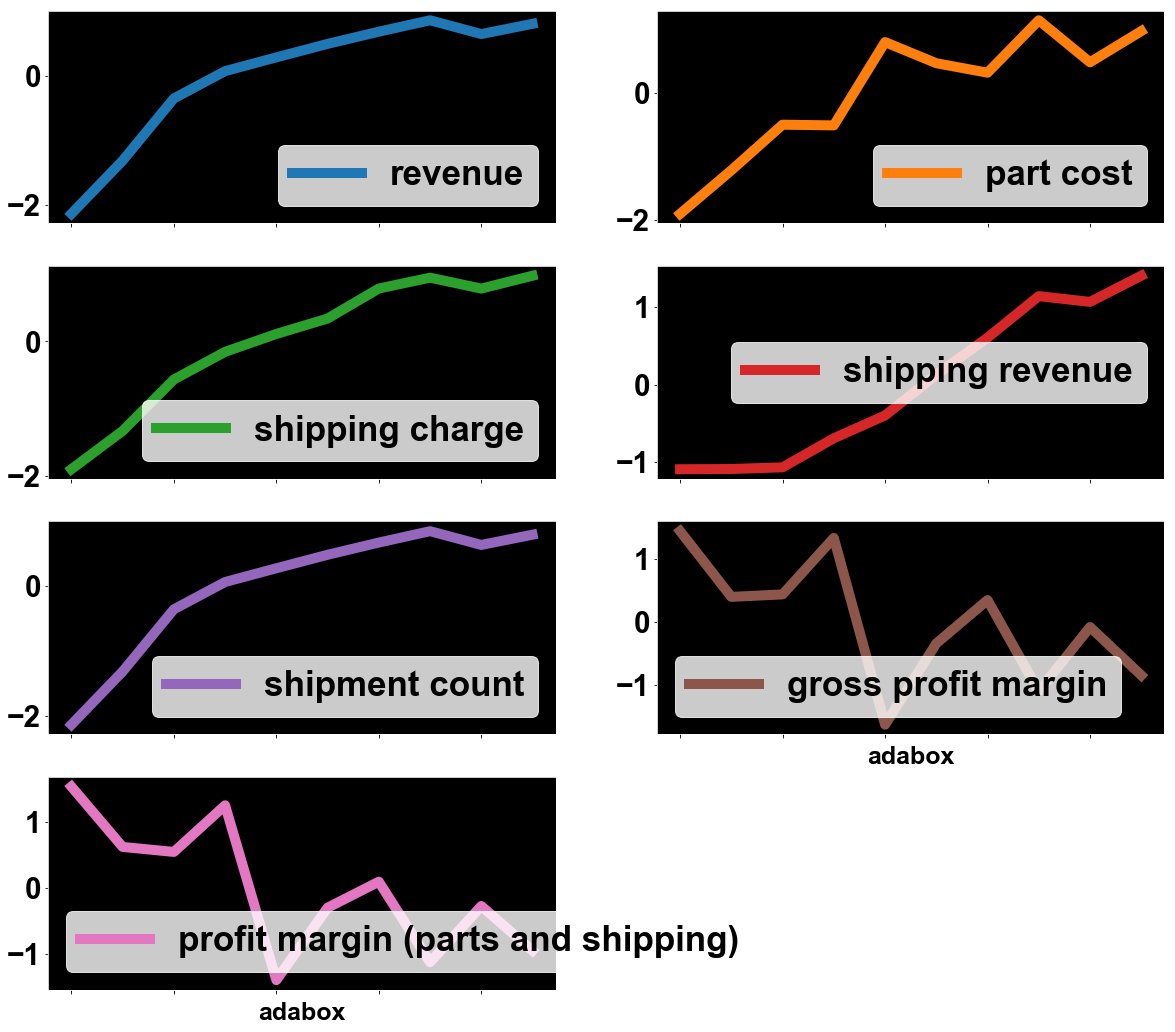

In [30]:
axes = z_scores.plot(subplots = True,
                     figsize = (20,20),
                     layout = (4,2))

plt.show()

### Avg per AdaBox

In [31]:
avg = money[['revenue','part cost','shipping charge','shipping revenue']].div(money['shipment count'], axis = 0)
avg.rename(columns = {'part cost':'avg cost',
                      'revenue':'avg revenue',
                      'shipping charge':'avg shipping charge',
                      'shipping revenue':'avg shipping revenue'}, inplace = True)

fmt = ['m2','m2','m2','m2']
avg.format_(fmt)

,Avg Revenue,Avg Cost,Avg Shipping Charge,Avg Shipping Revenue
adabox,,,,
AdaBox001,$60.00,$19.76,$8.95,$0.00
AdaBox002,$60.00,$24.47,$8.97,$0.00
AdaBox003,$60.00,$24.29,$9.55,$0.02
AdaBox004,$60.00,$20.24,$10.04,$0.22
AdaBox005,$60.00,$33.62,$10.50,$0.35
AdaBox006,$60.00,$27.80,$10.76,$0.58
AdaBox007,$60.00,$24.69,$11.92,$0.75
AdaBox008,$60.00,$31.21,$11.92,$0.94
AdaBox009,$60.00,$26.63,$12.05,$0.97


### Overall averages

In [32]:
print('avg across all boxes')
display(jb_mean(money, fmt))

avg across all boxes


,mean
Revenue,"$172,326.00"
Part Cost,"$78,376.09"
Shipping Charge,"$31,851.24"
Shipping Revenue,"$1,764.00"
Shipment Count,2872.1
Gross Profit Margin,0.562017
Profit Margin (Parts And Shipping),0.38927


### Money chart

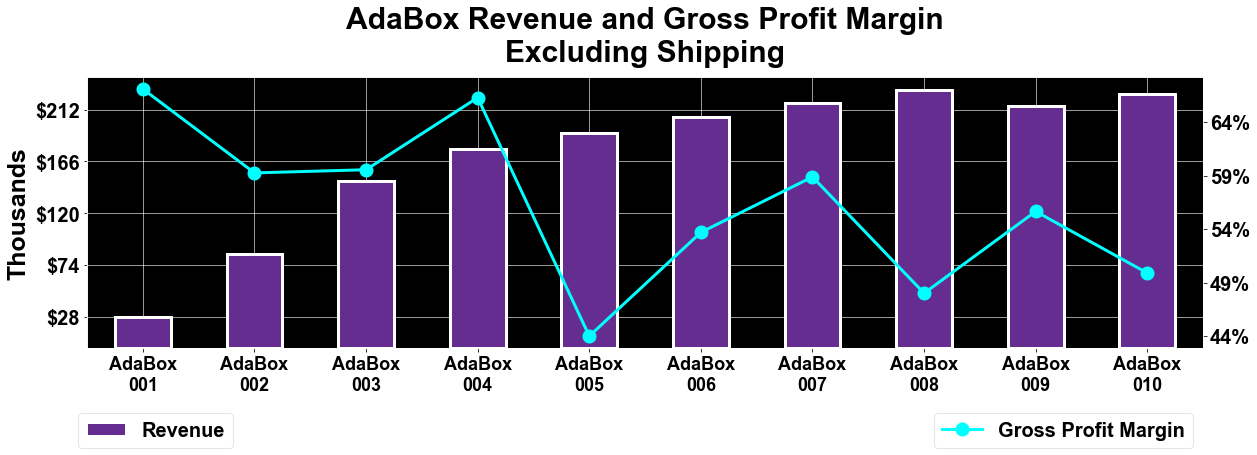

In [33]:
fig, ax = plt.subplots(figsize = (20,5))

money[['revenue']].plot(kind = 'bar',
                        ax = ax,
                        color = colors[3],
                        edgecolor = 'white',
                        linewidth = 3,
                        zorder = 5)

m1 = money[['revenue']].values.min()
m2 = money[['revenue']].values.max()
yticks = np.arange(m1,m2,m2/5)
yticks = [np.round(x/1000) * 1000 for x in yticks]
ax.set_yticks(yticks)

ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Thousands')

ax.set_title('AdaBox Revenue and Gross Profit Margin\nExcluding Shipping', y = 1.04, fontsize = 30)
ax.set_xlabel('', labelpad = 10)
ax.legend(['Revenue'], edgecolor = 'black', bbox_to_anchor = (0.14, -0.2), framealpha = 0.1, fontsize = 20)

ax2 = ax.twinx()
money[['gross profit margin']].plot(ax = ax2,
                                   lw = 3,
                                   marker = 'o',
                                   mew = 8,
                                   color = colors[0],
                                   zorder = 5)

m1 = money[['gross profit margin']].values.min()
m2 = money[['gross profit margin']].values.max()
yticks = np.arange(m1,m2,0.05)
ax2.set_yticks(yticks)

ax2.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax2.get_yticks()], fontsize = 20)
ax2.set_ylabel('')
ax2.legend(['Gross Profit Margin'], edgecolor = 'black', bbox_to_anchor = (1, -0.2), framealpha = 0.1, fontsize = 20)

xticks = [x[:-3] + '\n' + x[-3:] for x in money.index]
ax.set_xticklabels(xticks, rotation = 0, fontsize = 18)
ax.grid(color = 'white', alpha = 0.75, zorder = 0)

plt.savefig(image_path + 'Revenue and Gross Profit Margin', bbox_inches = 'tight')
plt.show()

### For report: revenue

In [34]:
a = money.iloc[-1]['revenue']
b = money.iloc[-1]['shipping revenue']

w1 = 'Adabox revenue reached ${:,.0f} while shipping revenue hit ${:,.0f};'.format(a, b)

a = money.iloc[-1][['revenue','shipping revenue']].sum()
b = money.iloc[-5][['revenue','shipping revenue']].sum()
c = a/b-1

w2 = 'this makes for ${:,.0f} in total revenue, {} {:,.2f}% from last year\'s ${:,.0f}.'.format(a, 
                                                                                                'up' if c > 0 else 'down',
                                                                                               np.abs(c) * 100,
                                                                                               b)

write = ' '.join([w1,w2])
report_dict['revenue write'] = write
report_dict['revenue write']

"Adabox revenue reached $226,200 while shipping revenue hit $4,030; this makes for $230,230 in total revenue, up 11.10% from last year's $207,230."

### For report: cost

In [59]:
a = money.iloc[-1]['part cost']
b = money.iloc[-1]['shipping charge']
c = a + b
d = c / money.iloc[-1]['shipment count']

w1 = 'Part cost amounted to ${:,.0f} while the shipping cost came to ${:,.0f} for a total of ${:,.0f}, or ${:,.2f} per box.'.format(a,b,c,d)

a = money.iloc[-4:][['part cost','shipping charge']].sum(1).sum()
b = money.iloc[-4:]['shipment count'].sum()
c = a/b

if np.abs(d - c) < 5:
    ret = 'about equal to'
else:
    if d < c:
        ret = 'lower than'
    else:
        ret = 'higher than'

w2 = 'This cost-per-box is {} the four-quarter average of ${:,.2f}.'.format(ret, c)

report_dict['cost write 01'] = ' '.join([w1,w2])
print(report_dict['cost write 01'])

a = money.iloc[-1]['shipping charge']/money.iloc[-1]['shipment count']
b = money.iloc[-4:]['shipping charge'].sum()/money.iloc[-4:]['shipment count'].sum()

if np.abs(a - b) < 2:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'lower than'
    else:
        ret = 'higher than'

w3 = 'Focusing now only on shipping, the cost averaged ${:,.2f} per box, {} the four-quarter average of ${:,.2f}.'.format(a,ret,b)
report_dict['cost write 02'] = w3
print('')
print(report_dict['cost write 02'])

Part cost amounted to $113,409 while the shipping cost came to $46,067 for a total of $159,477, or $42.30 per box. This cost-per-box is about equal to the four-quarter average of $40.24.

Focusing now only on shipping, the cost averaged $12.22 per box, about equal to the four-quarter average of $12.03.


### For report: gross profit

In [65]:
a = money.iloc[-1]['gross profit margin']
b = money.iloc[-4:]['gross profit margin'].mean()

if np.abs(a - b) < 0.02:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'lower than'
    else:
        ret = 'higher than'

w1 = 'When we exclude shipping, the gross profit margin was {:,.2f}%, {} than the four-quarter average of {:,.2f}%.'.format(a * 100, ret, b * 100)

a = money.iloc[-1]['profit margin (parts and shipping)']
b = money.iloc[-4:]['profit margin (parts and shipping)'].mean()

if np.abs(a - b) < 0.02:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'lower than'
    else:
        ret = 'higher than'
        
w2 = 'When we factor in shipping, the margin becomes {:,.2f}%, {} the four-quarter average of {:,.2f}%.'.format(a * 100, ret, b * 100)

write = ' '.join([w1,w2])
report_dict['margin write'] = write
report_dict['margin write']

'When we exclude shipping, the gross profit margin was 49.86%, lower than than the four-quarter average of 53.08%. When we factor in shipping, the margin becomes 30.73%, lower than the four-quarter average of 34.07%.'

# Churn rate 
* It's tempting to calculate churn by AdaBox, versus the year and quarter, but this is not possible because someone may sign up on a date directly in between two AdaBoxes, so which AdaBox would this sign-up belong to?
* Also note that we DO NOT correct the date shipped of any AdaBox that was shipped late or early.

In [37]:
# some adabox shipped dates straddle quarters
# fix that here so that we can calculate churn on the year_and_quarter level

for_churn = subs_main.copy()

'''
for_churn['action date'] = np.where((for_churn['shipment slug'] == 'adabox_8') | (for_churn['action date'].between('2018-07-01','2018-07-07')),
                                   pd.to_datetime(['2018-06-01']), for_churn['action date'])

for_churn['action date'] = np.where((for_churn['shipment slug'] == 'adabox_9') | (for_churn['action date'].between('2018-10-01','2018-10-07')),
                                   pd.to_datetime(['2018-09-01']), for_churn['action date'])

'''
# to datetime
ls = ['action date','date created']
for col in ls:
    for_churn[col] = pd.to_datetime(for_churn[col])  

# create "year and quarter"
for_churn['year and quarter created'] = for_churn['date created'].dt.year.map(str) + '-Q' + for_churn['date created'].dt.quarter.map(str)
for_churn['year and quarter action'] = for_churn['action date'].dt.year.map(str) + '-Q' + for_churn['action date'].dt.quarter.map(str)

In [38]:
# includes gift redemptions
a1 = for_churn[for_churn['action'] == 'create subscription'].copy()
a2 = a1.groupby('year and quarter action')[['subscriptions id']].nunique()
a2.columns = ['created']

b1 = for_churn[for_churn['account status'] == 'cancelled']
b1 = b1.sort_values(['subscriptions id','action date']).drop_duplicates('subscriptions id', keep = 'last')
b2 = b1.groupby('year and quarter action')[['subscriptions id']].count()
b2.columns = ['cancelled']

statuses = list(set(for_churn['account status']))
statuses.remove('active')
print('the "account statuses" that you are considering are {}'.format(', '.join(statuses)))

invol = statuses.copy()
invol.remove('cancelled')

c1 = for_churn[for_churn['account status'].isin(invol)].copy()
c1.sort_values(['subscriptions id','action date'], inplace = True)
c1.drop_duplicates('subscriptions id', keep = 'last', inplace = True)
c2 = c1.groupby(['year and quarter action','account status'])[['account status']].count().unstack(1).fillna(0)
c2.columns = c2.columns.droplevel(0)

the "account statuses" that you are considering are cancelled, expired, payment invalid


In [39]:
churn = a2.join(b2).join(c2).fillna(0)

churn['voluntary churn'] = churn['cancelled']/(churn['created'].cumsum() - churn['cancelled'].cumsum().shift(1))

churn['involuntary churn'] = churn[invol].sum(1)/(churn['created'].cumsum() - churn[invol].sum(1).cumsum().shift(1))
churn['overall churn'] = churn[statuses].sum(1)/(churn['created'].cumsum() - churn[statuses].sum(1).cumsum().shift(1))

# check churn counts with PLM counts
for ix in plm.index:
    
    v1 = plm[ix]
    
    if ix != 'active':
        v2 = churn.sum()[ix]
    else:
        v2 = churn.sum()['created'] - churn[statuses].sum(1).sum()
        
    if v1 == v2:
        print(ix + ': match')
    else:
        raise ValueError(ix + ': mismatch')
        
# restrict by quarter
churn = churn[churn.index <= quarter_end]

fmt = ['n0','n0','n0','n0','p2','p2','p2']
print('\nfour-quarter average ')
display(jb_mean(churn.iloc[-4:], fmt))

churn.format_(fmt).replace('nan%','')

active: match
cancelled: match
expired: match
payment invalid: match

four-quarter average 


,mean
Created,594
Cancelled,358
Expired,171
Payment Invalid,0
Voluntary Churn,6.90%
Involuntary Churn,2.91%
Overall Churn,12.13%


,Created,Cancelled,Expired,Payment Invalid,Voluntary Churn,Involuntary Churn,Overall Churn
year and quarter action,,,,,,,
2016-Q3,"1,457",19,0,0,,,
2016-Q4,599,128,0,0,6.28%,0.00%,6.28%
2017-Q1,752,123,135,0,4.62%,4.81%,9.70%
2017-Q2,921,195,107,0,5.64%,2.98%,9.09%
2017-Q3,646,239,169,0,6.11%,4.09%,11.12%
2017-Q4,726,256,224,0,5.82%,4.78%,12.04%
2018-Q1,654,286,172,0,5.96%,3.36%,11.01%
2018-Q2,618,266,6,0,5.19%,0.11%,6.30%
2018-Q3,350,446,207,0,8.56%,3.50%,14.85%


### For report: churn

In [68]:
d = {'voluntary churn':['cancelled'],
    'involuntary churn':[x for x in statuses if x != 'cancelled']}

w1 = 'Churn can be divided into voluntary churn ({}) and involuntary churn ({}).'.format(', '.join(d['voluntary churn']), 
                                                                                         ', '.join(d['involuntary churn']))



report_dict['churn write 01'] = w1

a = churn.iloc[-1]['voluntary churn']
b = churn.iloc[-4:]['voluntary churn'].mean()

if np.abs(a-b) < 0.01:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'less than'
    else:
        ret = 'greater than'

w2 = 'For {}, the voluntary churn was {:,.2f}%, {} the four-quarter average of {:,.2f}%.'.format(pretty_year_and_quarter,
                                                                                               a * 100,
                                                                                               ret,
                                                                                               b * 100)

report_dict['churn write 02'] = w2

a = churn.iloc[-1]['involuntary churn']
b = churn.iloc[-4:]['involuntary churn'].mean()

if np.abs(a-b) < 0.01:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'less than'
    else:
        ret = 'greater than'
        
w3 = 'The involuntary churn was {:,.2f}%, {} the four-quarter average of {:,.2f}%.'.format(a * 100,
                                                                                         ret,
                                                                                         b * 100)

report_dict['churn write 03'] = w3

a = churn.iloc[-1]['overall churn']
b = churn.iloc[-4:]['overall churn'].mean()

if np.abs(a-b) < 0.01:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'less than'
    else:
        ret = 'greater than'
        
w4 = 'The overall churn was {:,.2f}%, {} the four-quarter average of {:,.2f}%.'.format(a * 100,
                                                                                  ret,
                                                                                  b * 100)
report_dict['churn write 04'] = w4

for i in range(4):
    print(report_dict['churn write 0' + str(i + 1)])
    print('')

Churn can be divided into voluntary churn (cancelled) and involuntary churn (expired, payment invalid).

For Q4 2018, the voluntary churn was 7.88%, about equal to the four-quarter average of 6.90%.

The involuntary churn was 4.68%, greater than the four-quarter average of 2.91%.

The overall churn was 16.38%, greater than the four-quarter average of 12.13%.



### Direction of churn rates (trendline) (WORKING)

In [41]:
churn_ot = churn[['voluntary churn','involuntary churn','overall churn']]

ls = []
for i in range(len(churn_ot.columns)):
    x = np.array(range(4))
    y = churn_ot.iloc[-4:,i].values
    slope = np.polyfit(x,y,1)[0]
    ls.append(slope)

In [42]:
print('direction of churn over most recent four quarters:\n')
for i in range(len(ls)):
    print(churn_ot.columns[i])
    print('{:,.2f}%'.format(ls[i] * 100))
    print('')

direction of churn over most recent four quarters:

voluntary churn
0.91%

involuntary churn
0.73%

overall churn
2.47%



### Churn plot

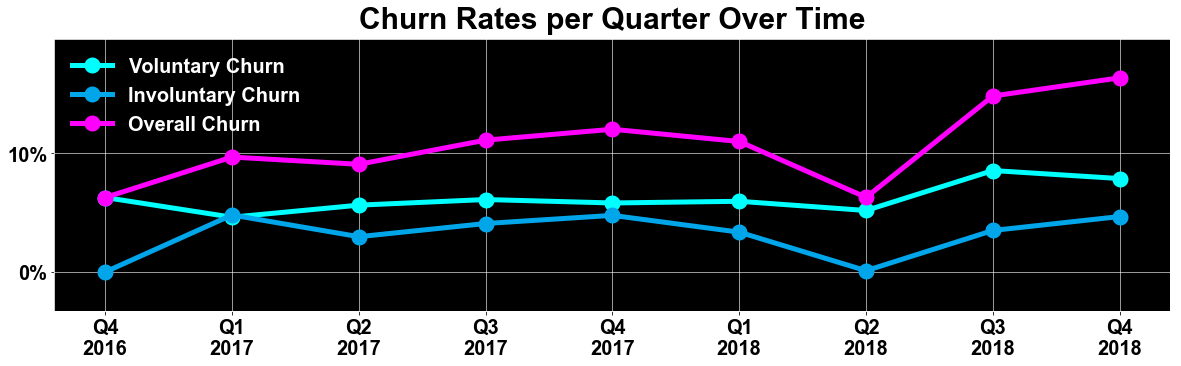

In [43]:
def pretty_qs(x):
    a = x.split('-')
    y = a[0]
    q = a[1]
    b = q + '\n' + y
    return b

fig, ax = plt.subplots(figsize = (20,5))

chart = churn[['voluntary churn','involuntary churn','overall churn']].dropna()
chart.columns = [x.title() for x in chart.columns]

chart.plot(ax = ax,
           lw = 5,
           marker = 'o',
           mew = 10,
           color = colors[0:3])

ax.grid(color = 'white', alpha = 0.75)
l = ax.legend(frameon = False, fontsize = 20, loc = 'upper left')
for text in l.get_texts():
    text.set_color('white')

m = chart.max().max()
m2 = m/5
ax.set_ylim(0 - m2, m + m2)
ax.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize = 20)
ax.set_title('Churn Rates per Quarter Over Time', y = 1.02, fontsize = 30)
ax.set_xticks(range(len(chart)))
ax.set_xticklabels([pretty_qs(x) for x in chart.index], fontsize = 20)
ax.set_xlabel('')

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Reasons for churn

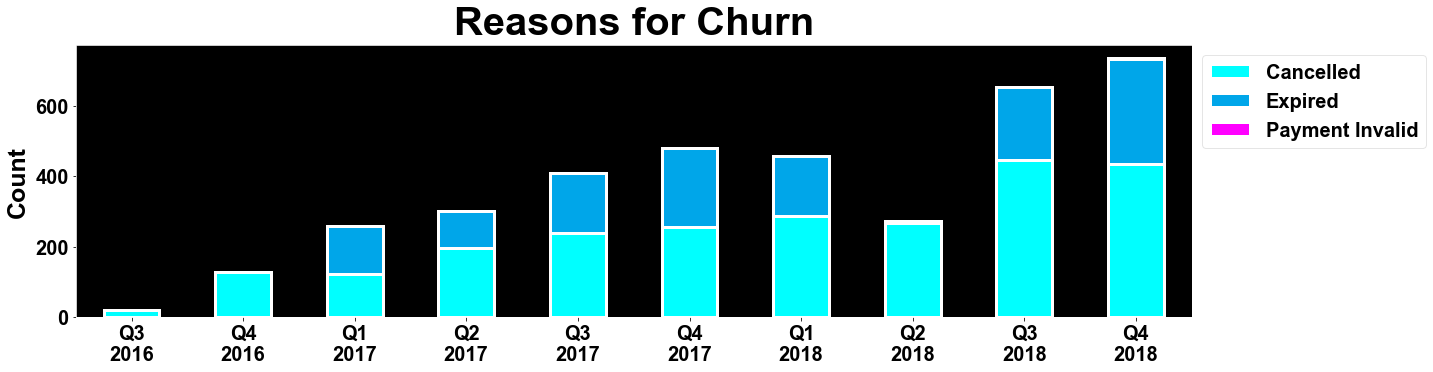

In [44]:
fig, ax = plt.subplots(figsize = (20,5))

chart = churn[statuses].dropna()
chart.columns = [x.title() for x in chart.columns]

chart.plot(ax = ax,
           color = colors,
           kind = 'bar',
           stacked = True,
           edgecolor = 'white',
           linewidth = 3)

ax.legend(edgecolor = 'black', bbox_to_anchor = (1,1), framealpha = 0.1, fontsize = 20)
ax.set_ylabel('Count')
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 20)
ax.set_title('Reasons for Churn', y = 1.02)
ax.set_xticks(range(len(chart)))
ax.set_xticklabels([pretty_qs(x) for x in chart.index], rotation = 0, fontsize = 20)
ax.set_xlabel('')

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### For report: reasons for churn

In [45]:
reasons = churn[statuses].copy()
reasons2 = reasons.div(reasons.sum(1), axis = 0).iloc[-4:].mean()

w1 = 'Looking now at the reasons for churn, on average and over the most recent four quarters, '
for i in range(len(reasons2)):
    if i != len(reasons2) - 1:
        w = reasons2.index[i] + ' makes up {:,.2f}%, '.format(reasons2[i] * 100)
    else:
        w = 'and ' + reasons2.index[i] + ' makes up {:,.2f}%.'.format(reasons2[i] * 100)
    
    w1 = w1 + w
    
report_dict['reasons for churn'] = w1
report_dict['reasons for churn']

'Looking now at the reasons for churn, on average and over the most recent four quarters, cancelled makes up 71.89%, expired makes up 28.04%, and payment invalid makes up 0.07%.'

# Subscription Counts
* This is not simply a count between two dates, it's more complicated; see the email "AdaBox009 subscription count" for more

# Shipment counts

In [46]:
counts = subs_clean[subs_clean['action'] == 'create shipment order'].groupby('adabox')[['subscriptions id']].nunique()
counts.columns = ['shipment count']
counts['q2q'] = counts['shipment count'].pct_change()
counts['yoy'] = counts['shipment count'].pct_change(periods = 4)

fmt = ['n0','p2','p2']

print('four-quarter avg')
display(jb_mean(counts.iloc[-4:], fmt))

counts.format_(fmt).replace('nan%','')

four-quarter avg


,mean
Shipment Count,"3,706"
Q2Q,2.59%
YOY,24.93%


,Shipment Count,Q2Q,YOY
adabox,,,
AdaBox001,471,,
AdaBox002,"1,394",195.97%,
AdaBox003,"2,474",77.47%,
AdaBox004,"2,948",19.16%,
AdaBox005,"3,187",8.11%,576.65%
AdaBox006,"3,421",7.34%,145.41%
AdaBox007,"3,633",6.20%,46.85%
AdaBox008,"3,831",5.45%,29.95%
AdaBox009,"3,592",-6.24%,12.71%


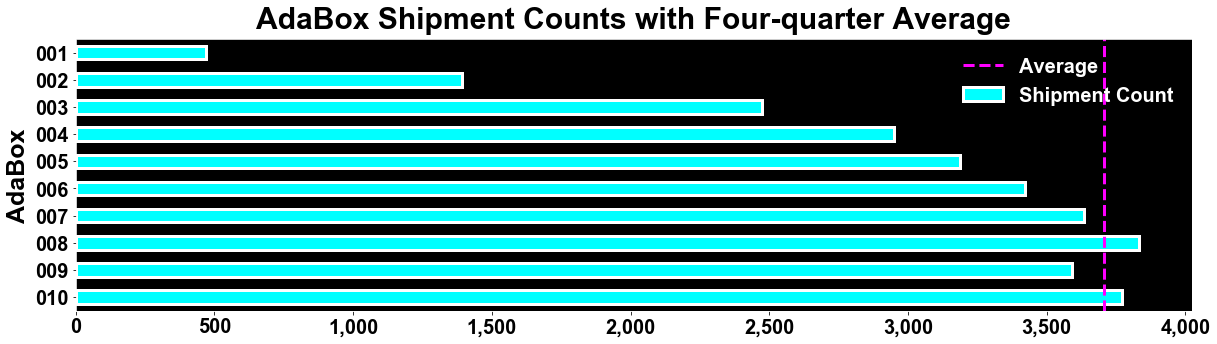

In [47]:
chart = counts[::-1]
chart.columns = [x.title() for x in chart.columns]

fig, ax = plt.subplots(figsize = (20,5))
chart['Shipment Count'].plot(ax = ax,
                             kind = 'barh',
                             color = colors[0],
                             edgecolor = 'white',
                             linewidth = 3)

m = chart.iloc[:4]['Shipment Count'].mean()
ax.axvline(m, color = adapink, ls = '--', lw = 3, label = 'Average')

l = ax.legend(fontsize = 20, loc = 'upper right', frameon = False)
for l2 in l.get_texts():
    l2.set_color('white')
    
ax.set_title('AdaBox Shipment Counts with Four-quarter Average', y = 1.02, fontsize = 30)
ax.set_ylabel('AdaBox')
ax.set_xlabel('')
ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()], fontsize = 20)

ix = [x[-3:] for x in counts.index.tolist()][::-1]
ax.set_yticklabels(ix, fontsize = 20)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### For report: shipment counts

In [48]:
a = counts.iloc[-1]['shipment count']
b = counts.iloc[-5]['shipment count']
c = a/b-1

if np.abs(a-b) < 50:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'down {:,.2f}% from'.format(np.abs(c) * 100)
    else:
        ret = 'up {:,.2f}% from'.format(np.abs(c) * 100)
        
w1 = '{} shipped to x{:,.0f} recipients, {} last year\'s x{:,.0f}.'.format(counts.index[-1],
                                                                           a,
                                                                           ret,
                                                                           b)

d = counts.iloc[-4:]['shipment count'].mean()

if np.abs(a-d) < 100:
    ret = 'about equal to'
else:
    if a < d:
        ret = 'below'
    else:
        ret = 'above'

w2 = 'This latest shipment count is {} the four-quarter average of x{:,.0f}.'.format(ret,
                                                                               d)

report_dict['shipment counts write'] = ' '.join([w1,w2])
report_dict['shipment counts write']

"AdaBox010 shipped to x3,770 recipients, up 10.20% from last year's x3,421. This latest shipment count is about equal to the four-quarter average of x3,706."

# Voids, returns, etc.

In [49]:
etc = subs_main[subs_main['action'] == 'create shipment order'].groupby(['adabox','orders status name'])[['subscriptions id']].count().unstack(1).fillna(0)
etc.columns = etc.columns.droplevel(0)
etc.format_(['n0'] * len(etc.columns))

,Replaced Defective,Shipped,Fraud - Confirmed,No Shipment Necessary,Return,Voided
adabox,,,,,,
AdaBox001,1,470,0,0,0,0
AdaBox002,2,"1,392",1,2,3,1
AdaBox003,0,"2,474",1,0,2,0
AdaBox004,0,"2,948",0,0,7,0
AdaBox005,0,"3,187",0,0,8,0
AdaBox006,0,"3,421",0,0,5,0
AdaBox007,0,"3,633",1,0,8,0
AdaBox008,0,"3,831",0,0,10,11
AdaBox009,0,"3,592",0,0,8,11


### PDF report

In [50]:
ls = sorted(list(set(subs_clean['adabox'])))
current_adabox_name = ls[-1]

report_title = current_adabox_name + ' Report'

pn = (list(set(subs_clean[subs_clean['adabox'] == current_adabox_name]['part id'])))[0]
pn = str(int(pn))

link1 = 'https://volcano.adafruit.com/volcano/ada_plm.php?/Parts/'
link2 = '/PartProfile/'

current_adabox_link = link1 + pn + link2

### Report summary

In [51]:
a = money['shipment count'].pct_change(periods = 4).iloc[-1]
w1 = 'Year over year, shipment counts were {} {:,.0f}%;'.format('down' if a < 0 else 'up', np.abs(a) * 100) 

a = (money[['revenue','shipping revenue']].sum(1)).pct_change(periods = 4).iloc[-1]
w2 = 'revenue, including shipping, was {} {:,.0f}%;'.format('down' if a < 0 else 'up', np.abs(a) * 100)

a = money.iloc[-1][['part cost','shipping charge']].sum()/money.iloc[-1]['shipment count']
w3 = 'cost per box, including shipping, was ${:,.2f};'.format(a)

a = money.iloc[-1]['shipping charge']/money.iloc[-1]['shipment count']
w4 = 'shipping cost per box was ${:,.2f};'.format(a)

a = money.iloc[-1]['profit margin (parts and shipping)']
w5 = 'gross profit margin, including shipping, was {:,.2f}%;'.format(a * 100)

a = churn.iloc[-1]['overall churn']
w6 = 'overall churn rate was {:,.2f}%.'.format(a * 100)

write = ' '.join([w1,w2,w3,w4,w5,w6])
report_dict['summary write'] = write
report_dict['summary write']

'Year over year, shipment counts were up 10%; revenue, including shipping, was up 11%; cost per box, including shipping, was $42.30; shipping cost per box was $12.22; gross profit margin, including shipping, was 30.73%; overall churn rate was 16.38%.'

In [71]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'report_title':report_title,
                     'current_adabox_name':current_adabox_name,
                     'pretty_year_and_quarter':pretty_year_and_quarter,
                     'now':now_pretty,
                     'current_adabox_link':current_adabox_link,
                     'pn':pn,
                     
                      'summary_write':report_dict['summary write'],
                    
                     'shipment_counts_write':report_dict['shipment counts write'],
                    
                     'revenue_write':report_dict['revenue write'],
                     
                     'cost_write_01':report_dict['cost write 01'],
                     'cost_write_02':report_dict['cost write 02'],
                    
                     'margin_write':report_dict['margin write'],
                    
                     'churn_write_01':report_dict['churn write 01'],
                     'churn_write_02':report_dict['churn write 02'],
                     'churn_write_03':report_dict['churn write 03'],
                     'churn_write_04':report_dict['churn write 04'],
                    
                     'reasons_for_churn':report_dict['reasons for churn']}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [53]:
print('done')

done
